In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy
from scipy import signal 
from matplotlib import pyplot as plt

from filters import AdaptiveEqualizer2P, CDCompensator, Decimate, PulseFilter
from modulation import DemodulatorDQPSK, DemodulatorQPSK, ModulatorQPSK
from phase_recovery import ViterbiViterbi
from utils import samples_squared, bits_to_ints, ints_to_bits

In [4]:
def plot_signal(signal: np.ndarray) -> None:
    assert signal.ndim == 1
    assert signal.size > 0

    s_real = np.real(signal[:10000])
    s_imag = np.imag(signal[:10000])

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 6))

    # Constellation diagram.
    ax = axs[0][0]
    ax.scatter(s_real, s_imag, alpha=0.05)
    ax.axis("equal")
    ax.set_xlabel("In-phase")
    ax.set_ylabel("Quadrature")
    ax.axhline(color="black")
    ax.axvline(color="black")

    # Unused plot.
    axs[1][0].set_axis_off()

    # Signal (real component).
    ax = axs[0][1]
    ax.stem(s_real)
    ax.set_xlim(-4, 128)
    ax.set_xlabel("Sample")
    ax.set_ylabel("In-phase")

    # Signal (imaginary component).
    ax = axs[1][1]
    ax.stem(s_imag)
    ax.set_xlim(-4, 128)
    ax.set_xlabel("Sample")
    ax.set_ylabel("Quadrature")

    # Spectrum.
    axs[0][2].magnitude_spectrum(signal.tolist(), sides="twosided")
    axs[1][2].phase_spectrum(signal.tolist(), sides="twosided")

    fig.tight_layout()

    plt.show()

In [5]:
def find_period(seq) -> int | None:
    for p in range(1, 2000):
        for i, j in zip(seq, seq[p:]):
            if i != j:
                break
        else:
            return p
    return None

In [6]:
# Rotate by 45 deg to correct the weird constellation.
data_34 = scipy.io.loadmat("data/data_36.mat")["data"] * np.exp(1j * np.pi/4)

# Decoded DQPSK data.
data_refd = scipy.io.loadmat("data/refdata512.mat")["refdatad"].ravel()

# Just need to turn it into bits to match our demodulator.
refd_demod = ints_to_bits(data_refd, 2)

assert find_period(data_refd) == 512
assert find_period(refd_demod) == 1024

data_refd.size

100864

In [7]:
data_34.shape

(1000000, 4)

In [8]:
# Extract polarizations.
x = data_34[:, 1] + 1j * data_34[:, 0]
y = data_34[:, 3] + 1j * data_34[:, 2]
x.shape

(1000000,)

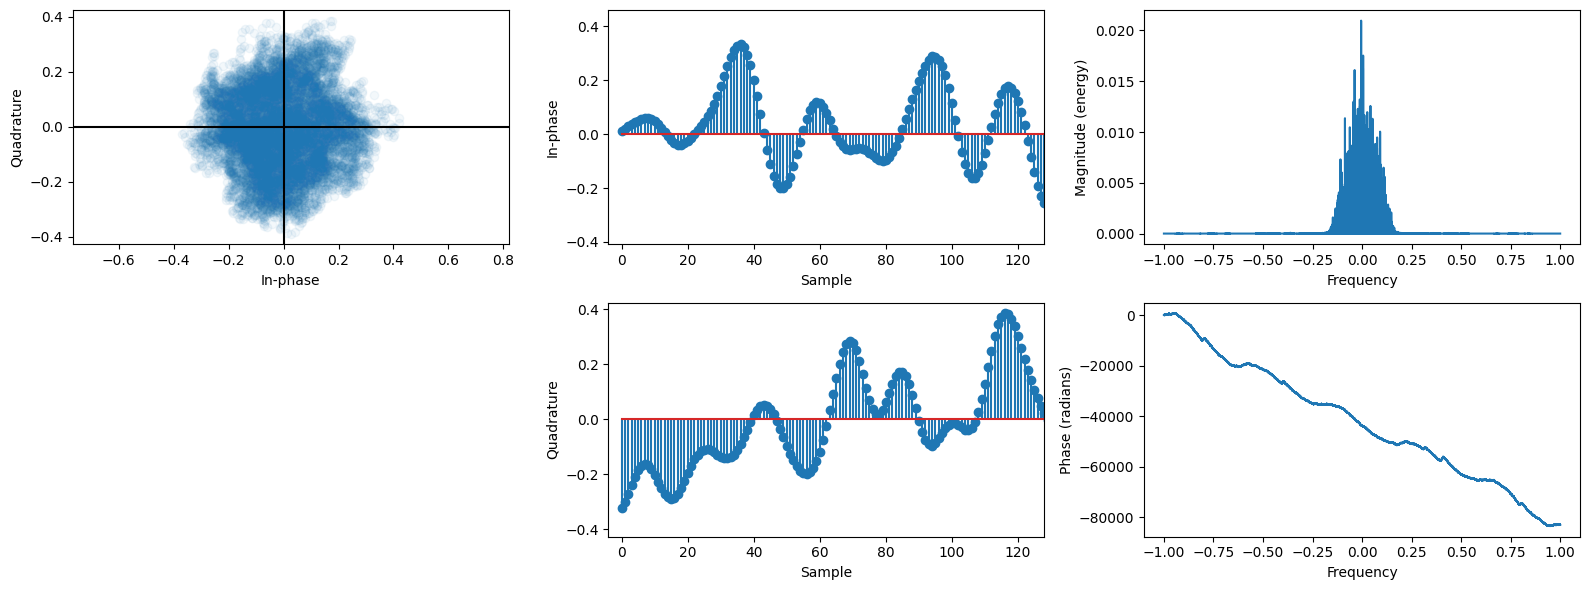

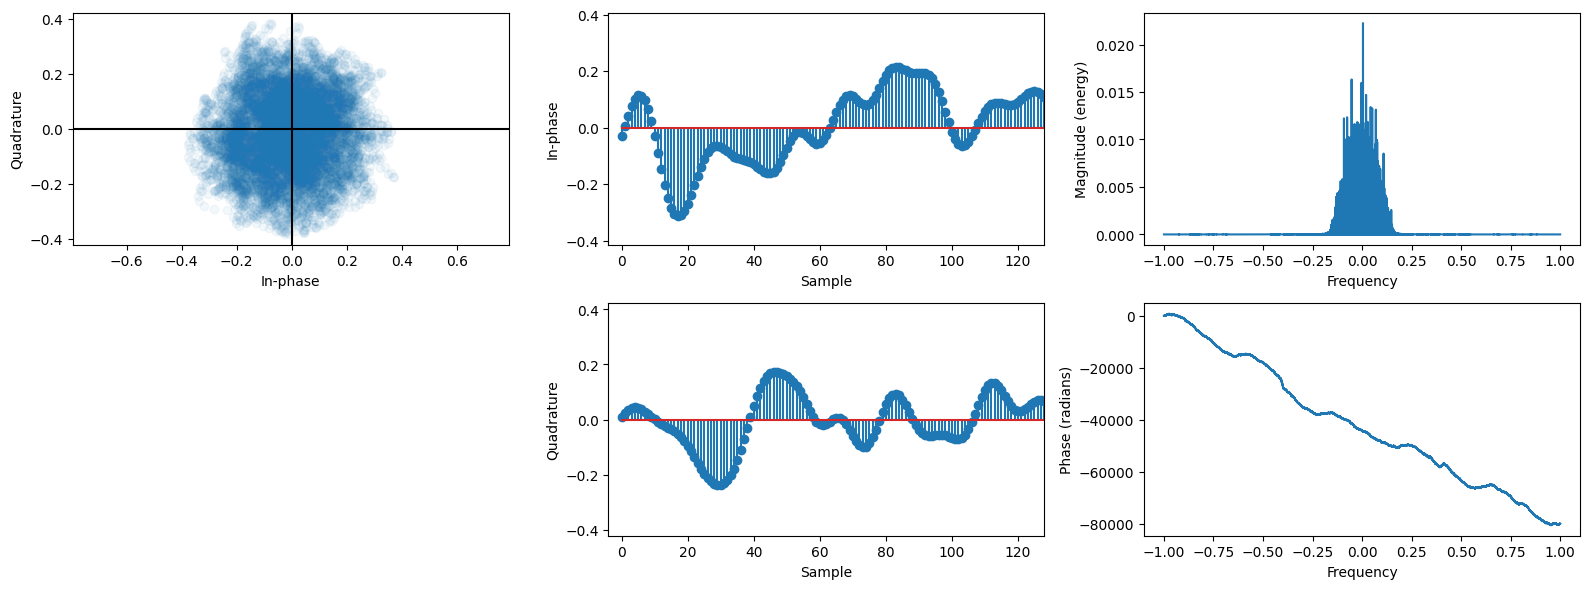

In [9]:
plot_signal(x)
plot_signal(y)

In [10]:
# Need to decimate from 100 GSamples/s to 20 GSamples/s
# (2 SpS @ 10 GBaud)
decimate = Decimate(5)
x_d = decimate(x)
y_d = decimate(y)

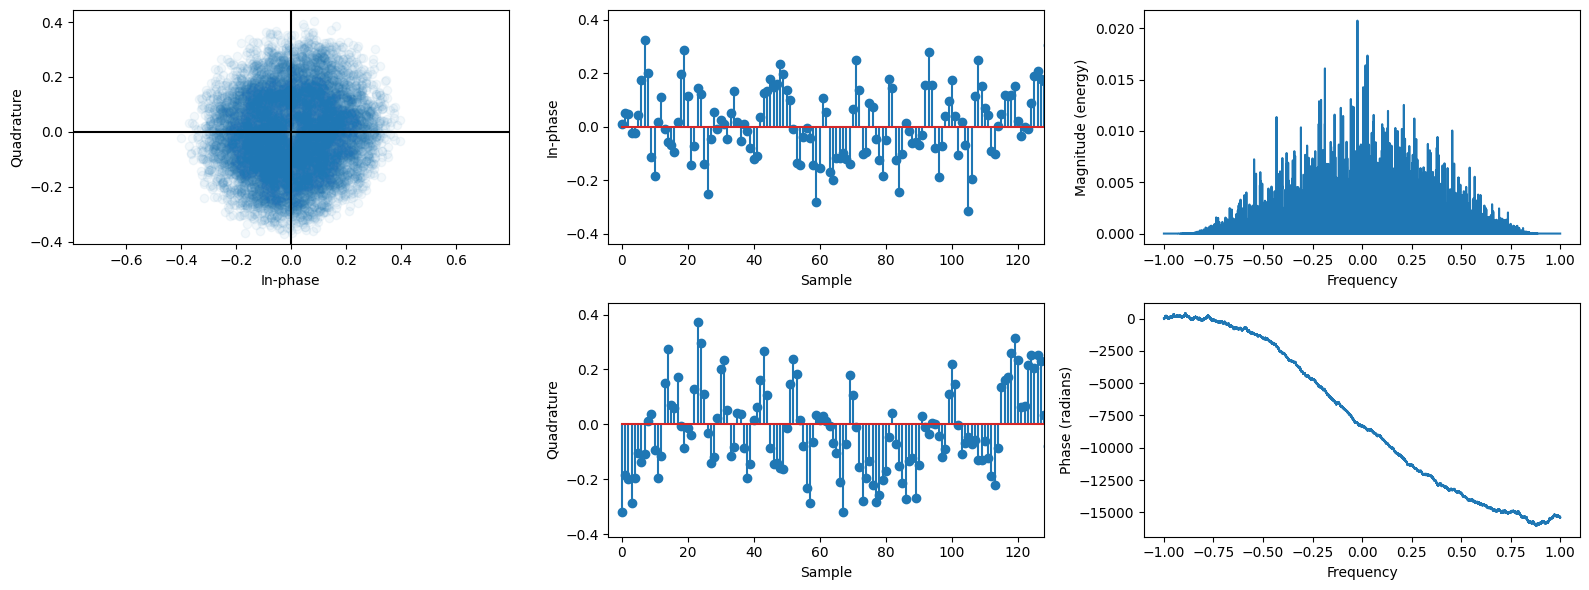

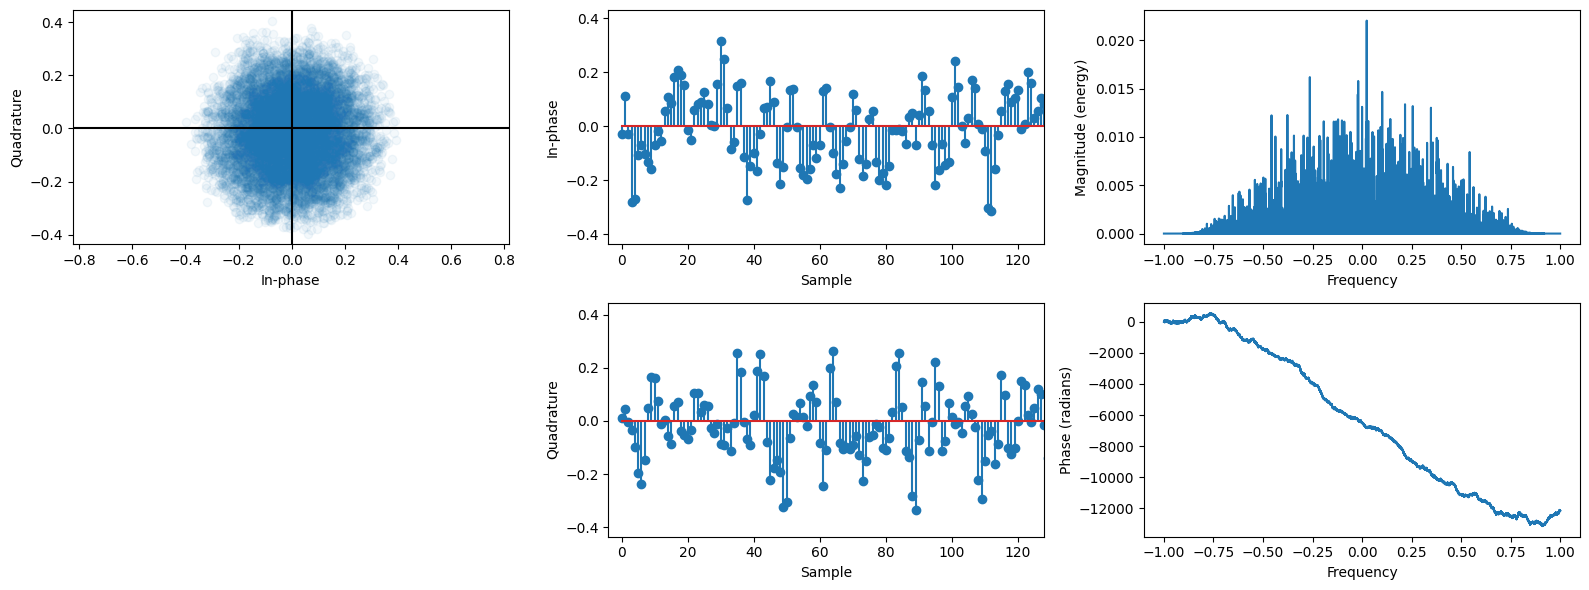

In [11]:
plot_signal(x_d)
plot_signal(y_d)

In [12]:
beta_estimate = (0.85 - 0.5) * 2
print(f"{beta_estimate = :.2f}")

# Compensate for Chromatic Dispersion (100 km transmission, so ~1600 ps/nm).
cdcompensator = CDCompensator(100_000, 20e9, 2, 127, pulse_filter_beta=beta_estimate)
x_cd = cdcompensator(x_d)
y_cd = cdcompensator(y_d)

beta_estimate = 0.70


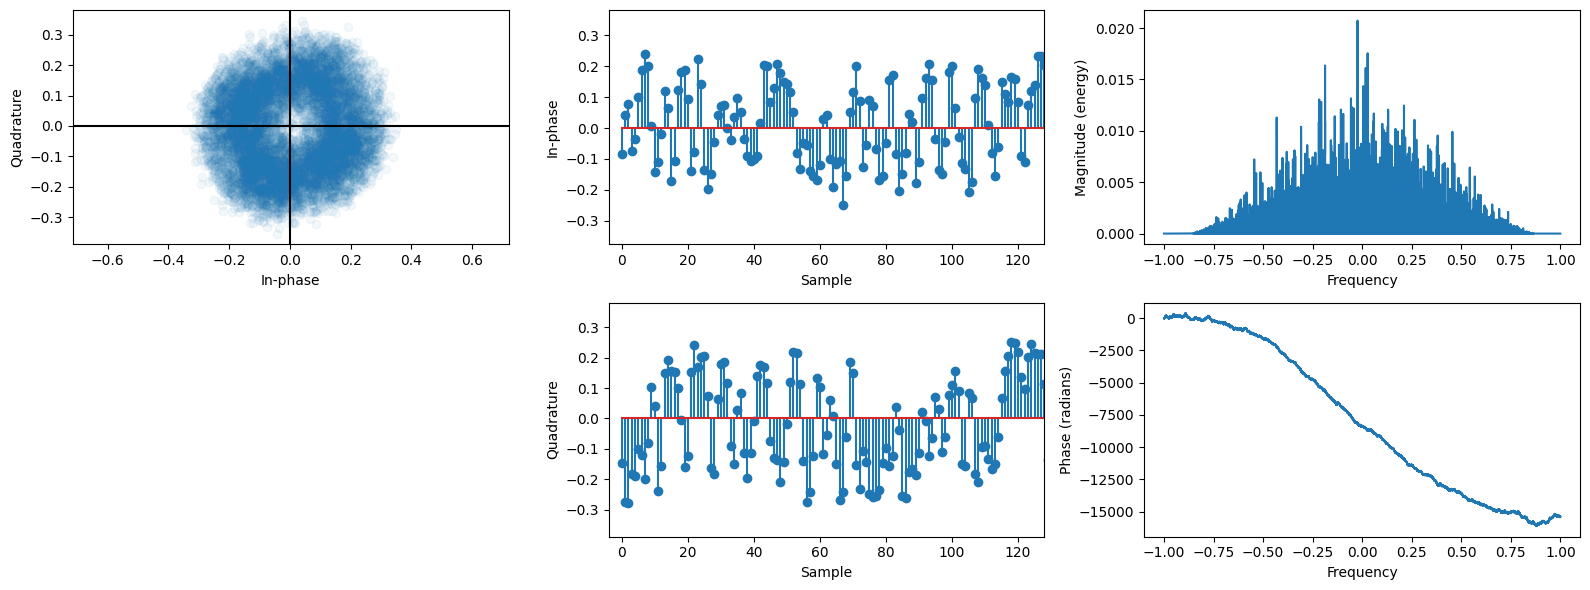

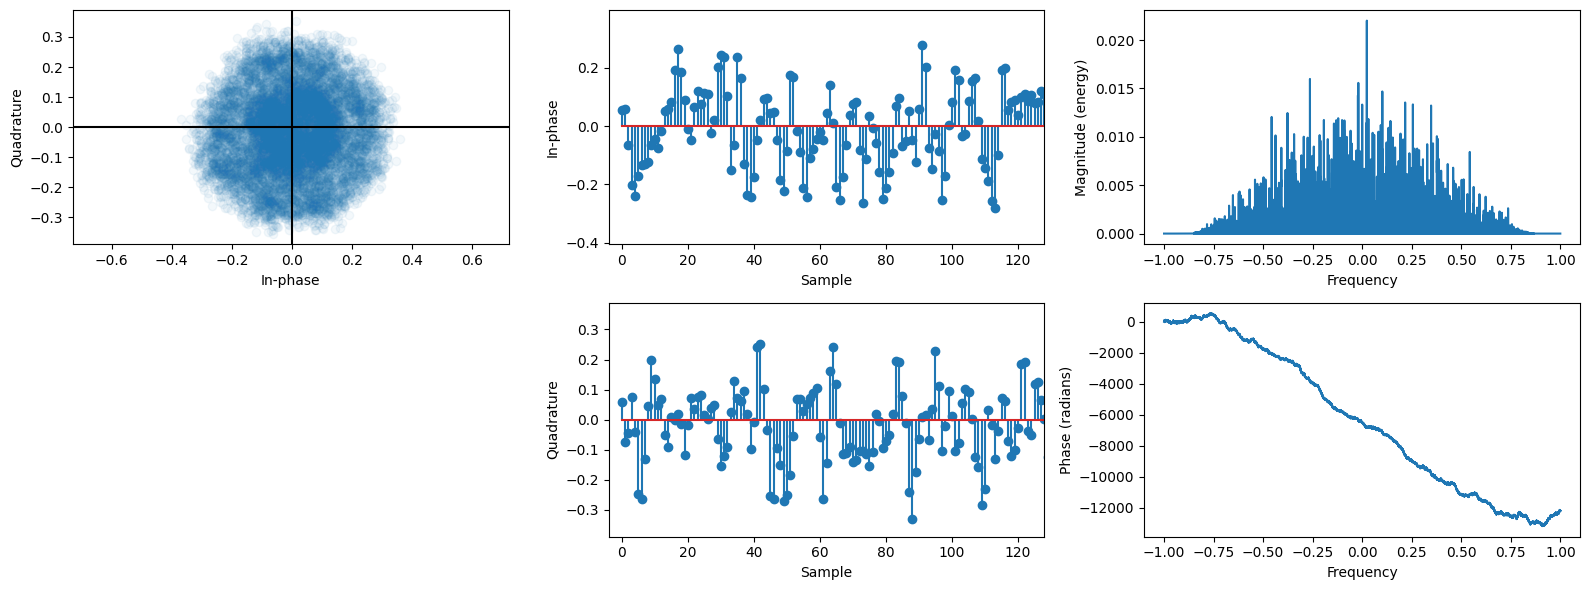

In [13]:
plot_signal(x_cd)
plot_signal(y_cd)

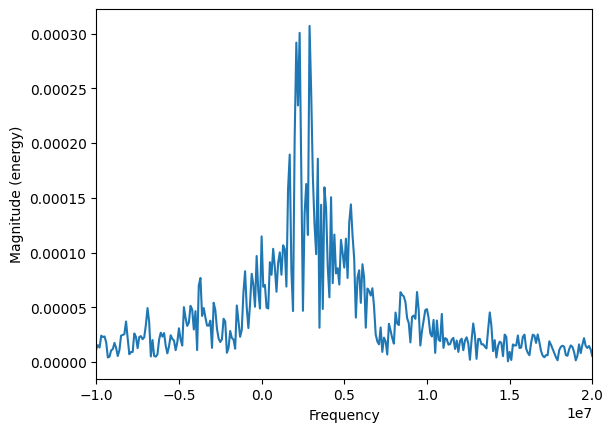

In [14]:
plt.magnitude_spectrum((x_cd**4).tolist(), Fs=20e9)
plt.xlim(-1e7, 2e7)
plt.show()

In [15]:
# Raise the signal to the 4th power to strip the data, find the frequency peak,
# and then divide again by 4 as the frequency was multiplied by the exponent
f_offset = np.fft.fftfreq(x_cd.size, 1/20e9)[np.argmax(np.abs(np.fft.fft(x_cd**4)))] / 4
print(f"{f_offset / 1e6:.3f} MHz")

0.525 MHz


In [16]:
# CMA equalization. XXX the adaptive equalizer DOWNSAMPLES 2 to 1.
a_eq = AdaptiveEqualizer2P(5, 1e-3)
a_eq.cma_to_rde_threshold = x.size * 2 # (only use CMA)

x_eq, y_eq = a_eq(np.row_stack((x_cd, y_cd * np.exp(1j * np.pi / 6))))

In [17]:
print(f"{np.abs(a_eq.w1V)=}")
print(f"{np.abs(a_eq.w1H)=}")
print(f"{np.abs(a_eq.w2V)=}")
print(f"{np.abs(a_eq.w2H)=}")

np.abs(a_eq.w1V)=array([0.05458322, 0.40938681, 0.85825469, 0.2575404 , 0.02487593])
np.abs(a_eq.w1H)=array([0.07760696, 0.46779911, 0.25529195, 0.11086688, 0.00485457])
np.abs(a_eq.w2V)=array([0.15131037, 0.72152231, 0.5257425 , 0.11063624, 0.0295809 ])
np.abs(a_eq.w2H)=array([0.03541563, 0.16511527, 0.60845497, 0.28373393, 0.04779741])


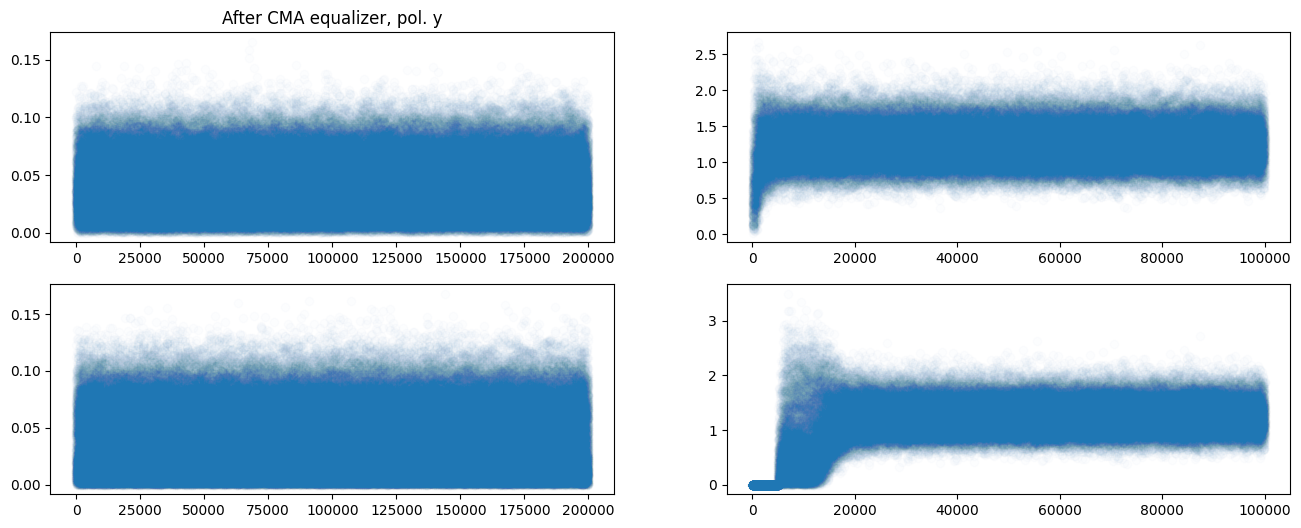

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16,6))
axs[0][0].scatter(range(x_cd.size), samples_squared(x_cd), alpha=0.01)
axs[0][0].set_title("Before CMA equalizer, pol. x")
axs[1][0].scatter(range(y_cd.size), samples_squared(y_cd), alpha=0.01)
axs[0][0].set_title("Before CMA equalizer, pol. y")
axs[0][1].scatter(range(x_eq.size), samples_squared(x_eq), alpha=0.01)
axs[0][0].set_title("After CMA equalizer, pol. x")
axs[1][1].scatter(range(y_eq.size), samples_squared(y_eq), alpha=0.01)
axs[0][0].set_title("After CMA equalizer, pol. y")
plt.show()

In [19]:
# Drop first 40_000 symbols, to ensure the adaptive equalizer has converged.
x_eqc = x_eq[40_000:]
y_eqc = y_eq[40_000:] * np.exp(-1j * np.pi / 6)

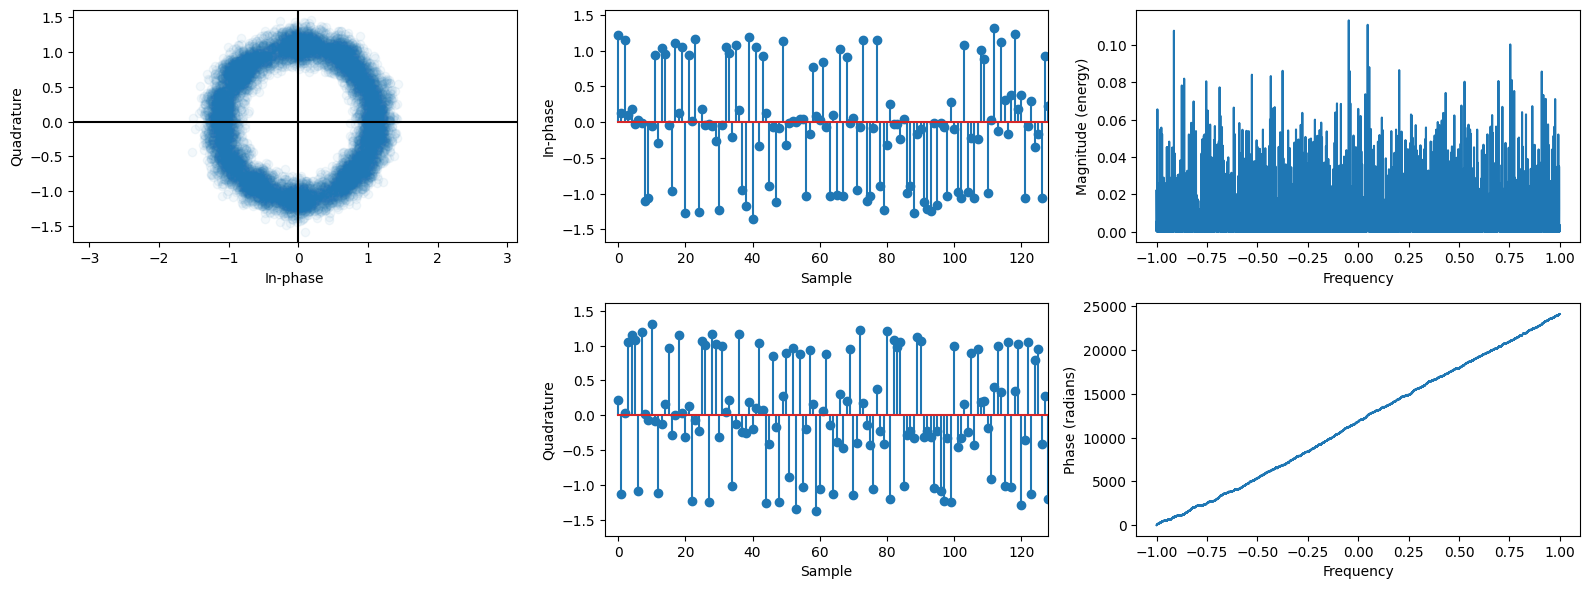

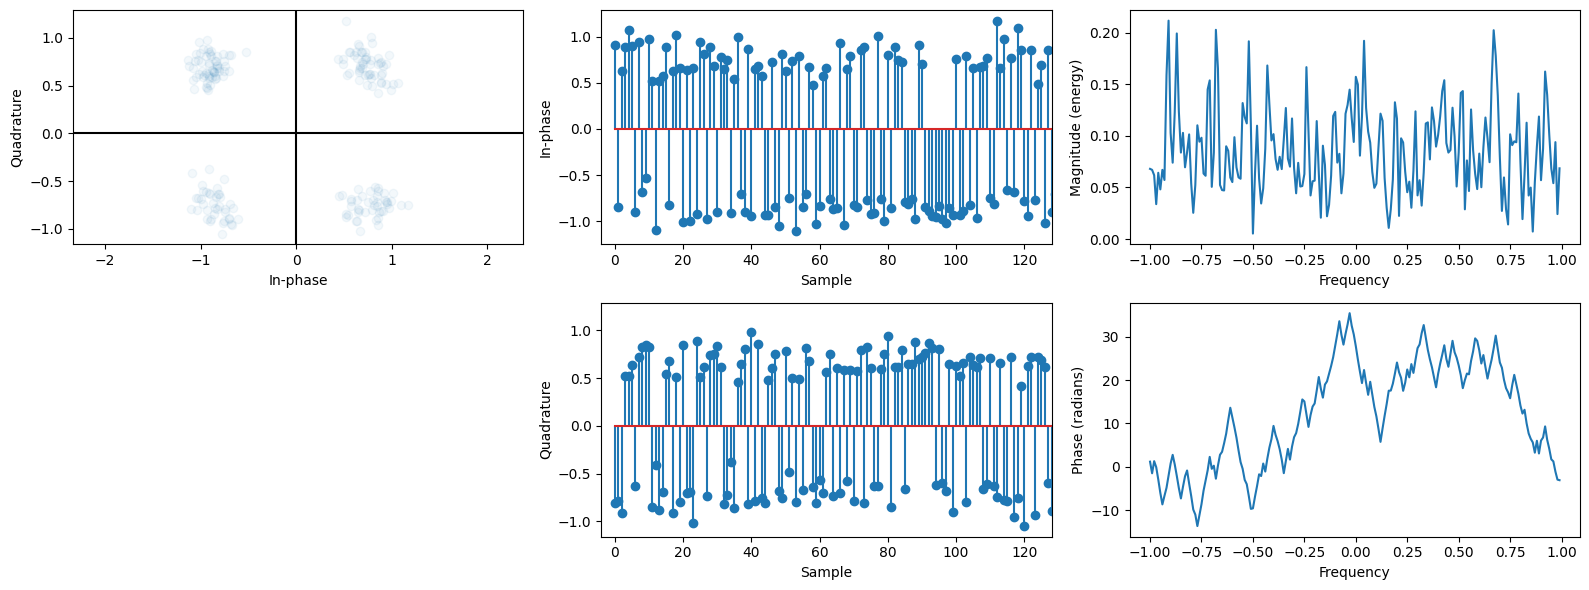

In [20]:
plot_signal(x_eqc)
plot_signal(y_eqc[:200])

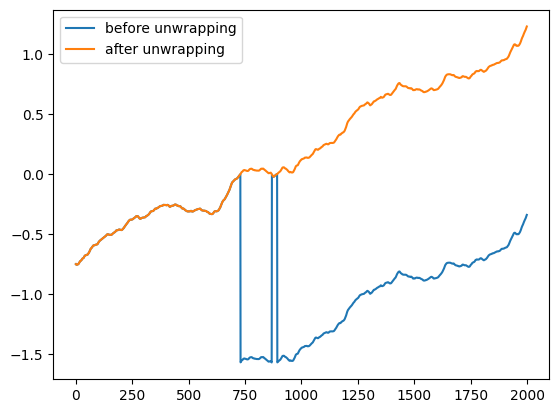

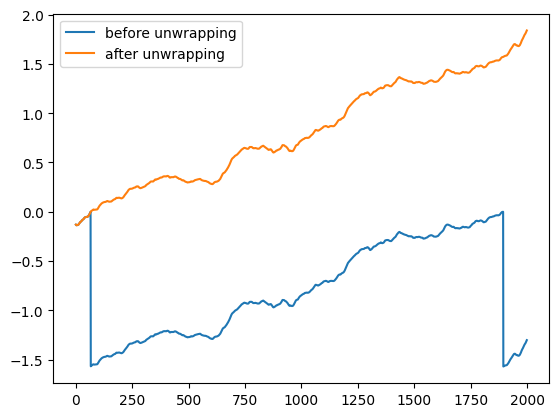

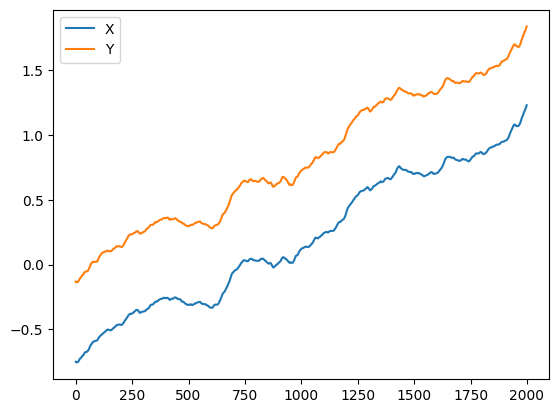

-0.6133199012754452

In [27]:
vv = ViterbiViterbi(ModulatorQPSK(), DemodulatorQPSK(), 64, 10e9, 400e3, 10)

x_vv = vv(x_eqc)
# Linear phase increase as we don't do frequency recovery
assert vv.last_estimates is not None
le_x = vv.last_estimates[:2000]
plt.plot(vv.last_raw[:2000], label="before unwrapping")
plt.plot(vv.last_estimates[:2000], label="after unwrapping")
plt.legend()
plt.show()
y_vv = vv(y_eqc)
# Linear phase increase as we don't do frequency recovery
assert vv.last_estimates is not None
le_y = vv.last_estimates[:2000]
plt.plot(vv.last_raw[:2000], label="before unwrapping")
plt.plot(vv.last_estimates[:2000], label="after unwrapping")
plt.legend()
plt.show()

plt.plot(le_x, label="X")
plt.plot(le_y, label="Y")
plt.legend()
plt.show()

np.mean(le_x) - np.mean(le_y)

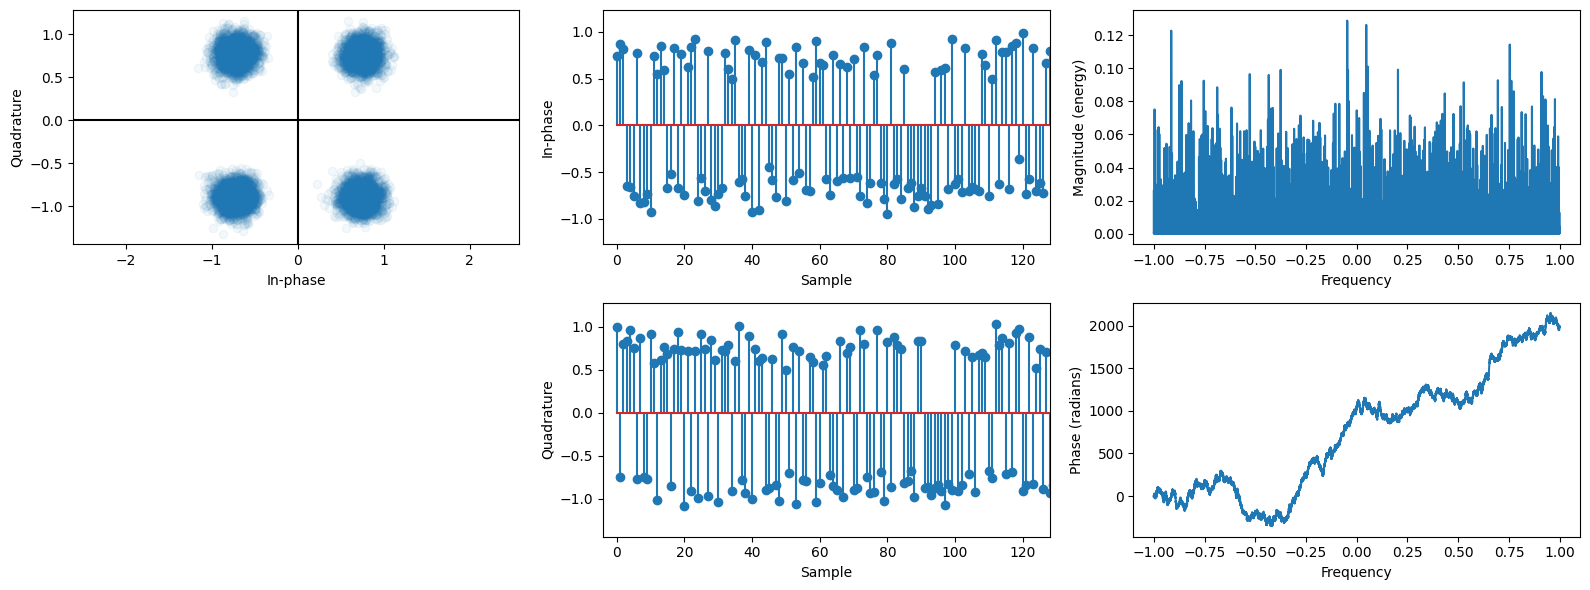

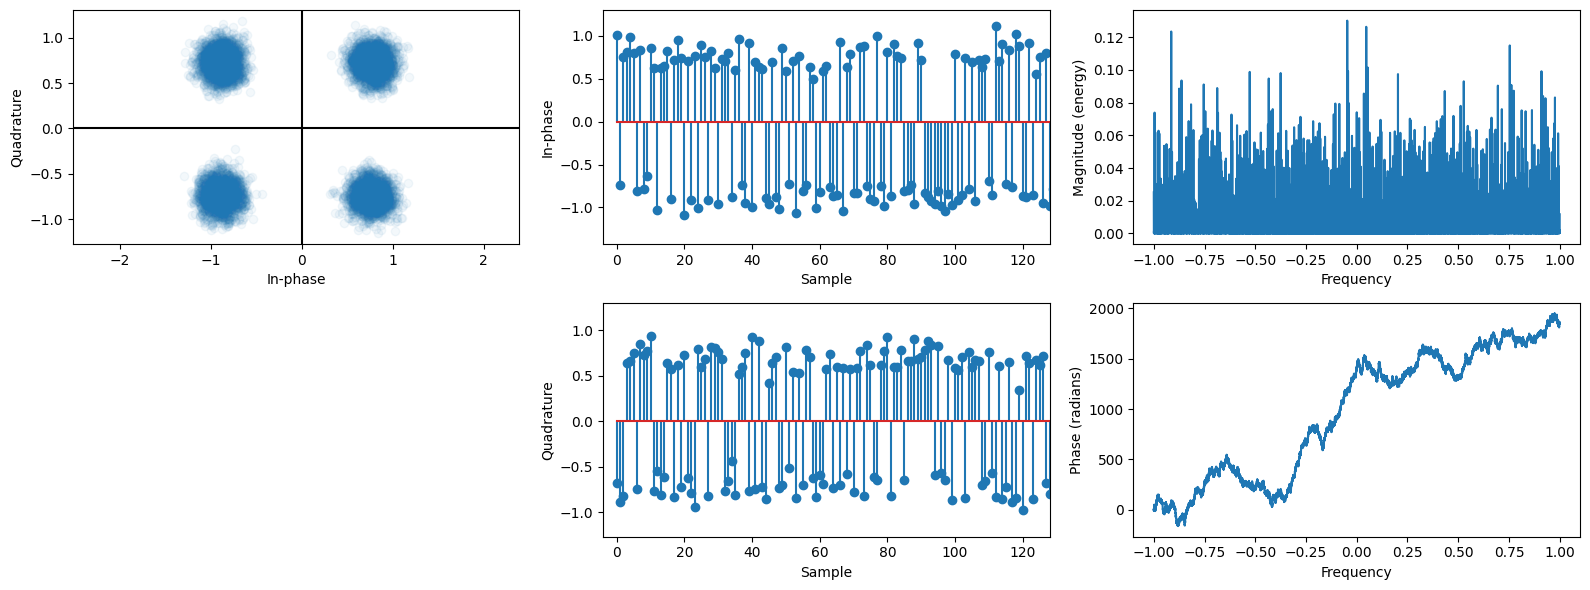

In [22]:
plot_signal(x_vv)
plot_signal(y_vv)

In [23]:
def find_lag(ref: np.ndarray, sig: np.ndarray) -> int:
    corr = signal.correlate(ref.astype(np.float64), sig.astype(np.float64))
    lags = signal.correlation_lags(ref.size, sig.size)
    lag = lags[np.argmax(corr)]
    assert lag >= 0
    return lag

In [24]:
x_demod = DemodulatorDQPSK()(x_vv)[1:]

lag = find_lag(refd_demod, x_demod)
ref_slice = refd_demod[lag : lag + x_demod.size]
ber = np.count_nonzero(x_demod ^ ref_slice) / x_demod.size

print(f"{ber} @ {lag} lag")

0.0 @ 10893 lag


In [25]:
# Drop last 10_000 bits, to ensure that lag + y_demod.size < x_demod.size.
y_demod = DemodulatorDQPSK()(y_vv)[1:-10_000]

lag = find_lag(x_demod, y_demod)
print(lag)
x_slice = x_demod[lag : lag + y_demod.size]
ber = np.count_nonzero(y_demod ^ x_slice) / y_demod.size

print(f"{ber} @ {lag} lag")

1024
9.090991736288513e-06 @ 1024 lag
